In [15]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp
from torchviz import make_dot
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import plotly.graph_objects as go
from IPython.display import display, clear_output
import plotly.express as px
import math

%matplotlib inline

In [20]:
class newDataset(Dataset):
    def __init__(self, image_files, mask_files, patch_size=512, patch_overlap=0.2, transform=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.transform=transform
        self.patch_size = patch_size
        self.patch_overlap = (1 - patch_overlap)
        self.all_patches = []
        self.initialize_patches()

    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        patch_image, patch_mask = self.all_patches[idx]

        if self.transform:
            patch_image,patch_mask=self.augment_image(patch_image,patch_mask)

        patch_image = torch.tensor(patch_image, dtype=torch.float32)
        patch_mask = torch.tensor(patch_mask, dtype=torch.float32)

        return patch_image, patch_mask
    
    def initialize_patches(self):
        for img_path, mask_path in zip(self.image_files, self.mask_files):
            image = cv2.imread(img_path, 0)
            mask = cv2.imread(mask_path, 0)

            image = self.image_histogram_equalization(image.astype('float32')/image.max())
            mask = mask.astype('float32')/255.

            self.all_patches.extend(self.extract_patches(image, mask))

    def extract_patches(self, image, mask):
        patches = []

        def calculate_dynamic_step(img_dim, patch_dim, overlap_fraction):
            print(patch_dim, overlap_fraction)
            overlap = int(patch_dim * overlap_fraction)
            step = patch_dim - overlap
            num_patches = math.ceil((img_dim - overlap) / step)
            step = (img_dim - patch_dim) / (num_patches - 1) if num_patches > 1 else 0
            return step, num_patches

        step_h, num_patches_h = calculate_dynamic_step(image.shape[0], self.patch_size, self.patch_overlap)
        step_w, num_patches_w = calculate_dynamic_step(image.shape[1], self.patch_size, self.patch_overlap)

        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step_h)
                x = int(j * step_w)
                patch_img = image[y:y + self.patch_size, x:x + self.patch_size]
                patch_mask = mask[y:y + self.patch_size, x:x + self.patch_size]
                patches.append((patch_img, patch_mask))

        return patches

    def image_histogram_equalization(self, image, number_bins=256):
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum() 
        cdf = (number_bins-1) * cdf / cdf[-1] 
        
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
        return image_equalized.reshape(image.shape)
    
    def augment_image(self, image, mask):
        shape = (*image.shape, 1 )
        image_np = image.reshape(shape).numpy()
        mask_np = mask.reshape(shape).numpy()
        augmented = self.transform(image = image_np,mask = mask_np)
        augmented_image , augmented_mask = augmented['image'],augmented['mask']
        augmented_image = augmented_image.reshape(augmented_image.shape[:-1])
        augmented_mask = augmented_mask.reshape(augmented_mask.shape[:-1])
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)
        augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32)
        
        return augmented_image,augmented_mask

    def calculate_num_patches(self, image_height, image_width):
        step_w = int(self.patch_size * self.patch_overlap)
        step_h = int(self.patch_size * self.patch_overlap)

        num_patches_w = math.ceil((image_width - self.patch_size) / step_w + 1)
        num_patches_h = math.ceil((image_height - self.patch_size) / step_h + 1)

        return num_patches_w * num_patches_h

class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice
    
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.should_stop = True

In [17]:
base_path = "C:\\Users\\Bartek\\Desktop\\mgr\\train"
dataset = "kidney_1_dense"

images_path = os.path.join(base_path,dataset,"images")
label_path = os.path.join(base_path,dataset,"labels")

image_files= sorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.tif')])
labels_files= sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if f.endswith('.tif')])

In [18]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, labels_files, test_size=0.2, random_state=42)

train_image_files[:5]

['C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\2122.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\1903.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0203.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\1883.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0981.tif']

In [21]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.OneOf(
        [
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.7,
    ),

])
train_dataset = newDataset(
    train_image_files, 
    train_mask_files,
    patch_size=(512,512),
    patch_overlap=0.2, 
    transform=transform)

#val_dataset = newDataset(val_image_files, 
#                         val_mask_files, 
#                         transform=transform
#                         )

TypeError: can't multiply sequence by non-int of type 'float'

In [14]:
import math

def calculate_num_patches(image_width, image_height, patch_width, patch_height, overlap_fraction=0):
    step_w = int(patch_width * (1 - overlap_fraction))
    step_h = int(patch_height * (1 - overlap_fraction))

    num_patches_w = math.ceil((image_width - patch_width) / step_w + 1)
    num_patches_h = math.ceil((image_height - patch_height) / step_h + 1)

    return num_patches_w * num_patches_h

image_width, image_height = 1928, 1928  # Example image dimensions
patch_width, patch_height = 512, 512   # Example patch dimensions
overlap_fraction = 0.2                 # 50% overlap

num_patches = calculate_num_patches(image_width, image_height, patch_width, patch_height, overlap_fraction)
print("Number of patches:", num_patches)

Number of patches: 25


In [13]:
def calculate_dynamic_step(img_dim, patch_dim, overlap_fraction):
    overlap = int(patch_dim * overlap_fraction)
    step = patch_dim - overlap
    num_patches = math.ceil((img_dim - overlap) / step)
    # Recalculate step size to distribute patches evenly across the image
    step = (img_dim - patch_dim) / (num_patches - 1) if num_patches > 1 else 0
    return step, num_patches

def extract_patches_with_uniform_overlap(img_h, img_w, patch_size, overlap_fraction):
    patches = []
    step_h, num_patches_h = calculate_dynamic_step(img_h, patch_size, overlap_fraction)
    step_w, num_patches_w = calculate_dynamic_step(img_w, patch_size, overlap_fraction)

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y = int(i * step_h)
            x = int(j * step_w)
            patch_coords = (x, x + patch_size, y, y + patch_size)
            patches.append(patch_coords)

    return patches

# Example usage
img_h, img_w = 1928, 1928  # Example image dimensions
patch_size = 512          # Example patch dimensions
overlap_fraction = 0.2    # 20% overlap

patches = extract_patches_with_uniform_overlap(img_h, img_w, patch_size, overlap_fraction)
for patch in patches:
    print(patch)

(0, 512, 0, 512)
(354, 866, 0, 512)
(708, 1220, 0, 512)
(1062, 1574, 0, 512)
(1416, 1928, 0, 512)
(0, 512, 354, 866)
(354, 866, 354, 866)
(708, 1220, 354, 866)
(1062, 1574, 354, 866)
(1416, 1928, 354, 866)
(0, 512, 708, 1220)
(354, 866, 708, 1220)
(708, 1220, 708, 1220)
(1062, 1574, 708, 1220)
(1416, 1928, 708, 1220)
(0, 512, 1062, 1574)
(354, 866, 1062, 1574)
(708, 1220, 1062, 1574)
(1062, 1574, 1062, 1574)
(1416, 1928, 1062, 1574)
(0, 512, 1416, 1928)
(354, 866, 1416, 1928)
(708, 1220, 1416, 1928)
(1062, 1574, 1416, 1928)
(1416, 1928, 1416, 1928)


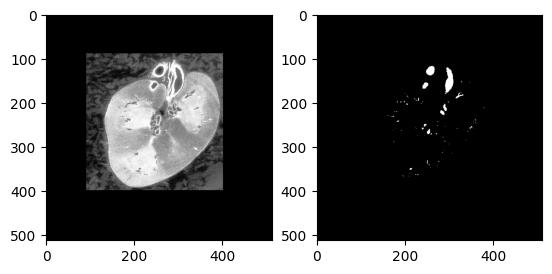

In [6]:
im, mask = train_dataset[45]
plt.subplot(1,2,1)
plt.imshow(im, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='grey')

In [7]:
train_dataloader= DataLoader(train_dataset,batch_size=6,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=6,shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.UnetPlusPlus(
    encoder_name='timm-resnest50d',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

#criterion = DiceLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device

device(type='cuda')

In [9]:
#dummy_input = torch.randn(1, 1, 928, 1312).to(device)  # Adjust the size as needed

#torch.onnx.export(model, dummy_input, "model.onnx", verbose=True)

In [10]:
#del dummy_input

In [11]:
torch.cuda.empty_cache()

In [12]:
def plot_losses(all_train_losses, train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(15, 5))

    # Subplot for detailed training loss per batch
    plt.subplot(1, 2, 1)
    plt.plot(all_train_losses, label='Batch Training Loss')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Detailed Training Loss')
    plt.legend()

    # Subplot for epoch-wise training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()

    plt.show()

In [13]:
fig = go.FigureWidget()
fig.add_scatter(name='Batch Training Loss')
fig.add_scatter(name='Epoch Training Loss')
fig.add_scatter(name='Epoch Validation Loss')

display(fig)

num_epochs = 50
early_stopping = EarlyStopping(patience=7, min_delta=0)
best_loss = float('inf')
all_train_losses = []
epoch_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []

    for batch_num, (images, masks) in enumerate(train_dataloader):
        b, h, w = images.shape
        images = images.reshape(b,1,h,w).to(device)
        masks = masks.reshape(b,1,h,w).to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
        all_train_losses.append(train_loss)
        epoch_train_losses.append(train_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_num+1}/{len(train_dataloader)}], Batch Loss: {train_loss:.8f}')

        fig.data[0].y = all_train_losses
        fig.data[0].x = list(range(len(all_train_losses)))

        

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    epoch_losses.append(avg_train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            b, h, w = images.shape
            images = images.reshape(b,1,h,w).to(device)
            masks = masks.reshape(b,1,h,w).to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

        avg_val_loss = running_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)


    fig.data[1].y = epoch_losses
    fig.data[1].x = list(range(len(epoch_losses)))
    fig.data[2].y = val_losses
    fig.data[2].x = list(range(len(val_losses)))

    if avg_val_loss < best_loss:  # Change to '>' if tracking accuracy
        print(f"Validation Loss Improved ({best_loss} --> {avg_val_loss})")
        best_loss = avg_val_loss  # Update best loss

        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved as best_model.pth")

    early_stopping(avg_val_loss)
    if early_stopping.should_stop:
        print("Early stopping triggered")
        break
print(f'DONE')

FigureWidget({
    'data': [{'name': 'Batch Training Loss', 'type': 'scatter', 'uid': '371173c7-356e-4f43-aec2-a98cea90e458'},
             {'name': 'Epoch Training Loss', 'type': 'scatter', 'uid': 'e7b04663-3c18-4d65-a030-73f3223a7906'},
             {'name': 'Epoch Validation Loss', 'type': 'scatter', 'uid': '9d5fb0b0-ee93-47d3-b687-c852f16d1319'}],
    'layout': {'template': '...'}
})

Epoch [1/50], Batch [1/304], Batch Loss: 0.48063755
Epoch [1/50], Batch [2/304], Batch Loss: 0.45018038
Epoch [1/50], Batch [3/304], Batch Loss: 0.40781564
Epoch [1/50], Batch [4/304], Batch Loss: 0.36459312
Epoch [1/50], Batch [5/304], Batch Loss: 0.35052776
Epoch [1/50], Batch [6/304], Batch Loss: 0.29885811
Epoch [1/50], Batch [7/304], Batch Loss: 0.30266231
Epoch [1/50], Batch [8/304], Batch Loss: 0.26119241
Epoch [1/50], Batch [9/304], Batch Loss: 0.23827331
Epoch [1/50], Batch [10/304], Batch Loss: 0.22066724
Epoch [1/50], Batch [11/304], Batch Loss: 0.20187685
Epoch [1/50], Batch [12/304], Batch Loss: 0.18825209
Epoch [1/50], Batch [13/304], Batch Loss: 0.19040692
Epoch [1/50], Batch [14/304], Batch Loss: 0.16912006
Epoch [1/50], Batch [15/304], Batch Loss: 0.16048202
Epoch [1/50], Batch [16/304], Batch Loss: 0.13122162
Epoch [1/50], Batch [17/304], Batch Loss: 0.12616172
Epoch [1/50], Batch [18/304], Batch Loss: 0.11839454
Epoch [1/50], Batch [19/304], Batch Loss: 0.10916062
Ep